In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import gpytorch
# from voltron.robinhood_utils import GetStockData
import os
# import robin_stocks.robinhood as r
import pickle5 as pickle

import sys
sys.path.append("../")
from voltron.likelihoods import VolatilityGaussianLikelihood
from voltron.kernels import BMKernel, VolatilityKernel
from voltron.models import BMGP, VoltronGP, SingleTaskVariationalGP
from voltron.means import LogLinearMean
from gpytorch.kernels import ScaleKernel, RBFKernel, MaternKernel

[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
Warning no robinhood utils.


In [2]:
sns.set_style('white')
# style.use('whitegrid')
palette = ["#1b4079", "#C6DDF0", "#048A81", "#B9E28C", "#8C2155", "#AF7595", "#E6480F", "#FA9500"]
sns.set(palette = palette, font_scale=2.0, style="white", rc={"lines.linewidth": 4.0})

In [3]:
torch.random.manual_seed(200)

In [4]:
ntest = 200
ntrain = 200
tckrs = [['BAC', 'GS', 'JPM', 'MS', 'WFC'], ['COP', 'CVX', 'EOG', 'SLB', 'XOM']]
indexes = ["XLF", "XLE"]
span = "5year"
interval = 'day'
T = 5.

['BAC' 'BRK.B' 'C' 'GS' 'JPM' 'MS' 'WFC']


<Figure size 720x360 with 0 Axes>

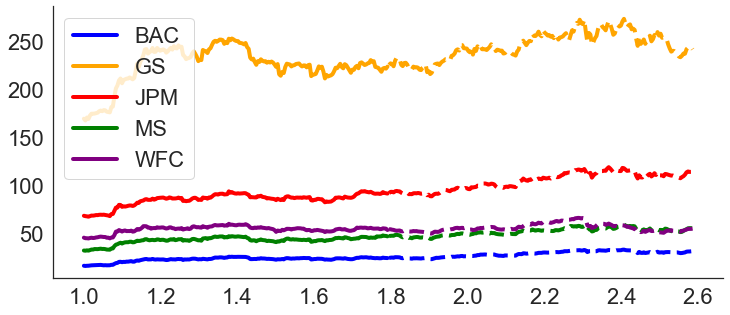

['COP' 'CVX' 'EOG' 'SLB' 'XOM']


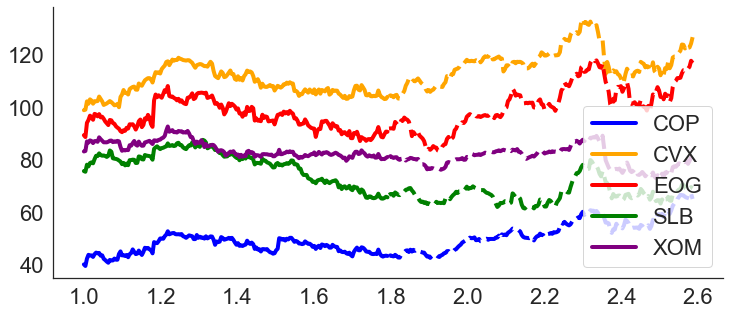

In [5]:
plt.figure(figsize = (10, 5))
idx = -2


colors = ["blue", "orange", "red", "green", "purple", "maroon"]

train_y_list = []
test_y_list = []
for j, (tckr1, loc) in enumerate(zip(tckrs, indexes)):
    with open("../../spdr-data/"+loc+".pkl", "rb") as handle:
        raw_data = pickle.load(handle)
    print(np.unique(raw_data["symbol"]))
    plt.figure(figsize = (12, 5))
    for i, tckr in enumerate(tckr1):
        data = raw_data[raw_data["symbol"] == tckr]
        ts = torch.linspace(0, T, data.shape[0]) + 1
        train_x = ts[:ntrain]
        test_x = ts[ntrain:(ntrain+ntest)]

        y = torch.FloatTensor(data['close_price'].to_numpy())
        train_y = y[:ntrain]
        test_y = y[ntrain:(ntrain+ntest)]

        dt = ts[1] - ts[0]
        train_y_list.append(train_y)
        test_y_list.append(test_y)

        plt.plot(train_x, train_y, label = tckr, color = colors[i])
        plt.plot(test_x, test_y, linestyle="--", color = colors[i])

        plt.legend()
    sns.despine()
    plt.show()

    train_y = torch.stack(train_y_list)
    test_y = torch.stack(test_y_list)

In [6]:
def get_and_fit_gpcv(x, log_returns):
    train_x = x[:-1]
    # prepare model
    likelihood = VolatilityGaussianLikelihood(param="exp")
    # likelihood.raw_a.data -= 6.
    covar_module = BMKernel()
    model = SingleTaskVariationalGP(
        init_points=train_x.view(-1,1), 
        likelihood=likelihood, 
        use_piv_chol_init=False,
        mean_module = gpytorch.means.ConstantMean(), 
        covar_module=covar_module, 
        learn_inducing_locations=False,
        use_whitened_var_strat=False,
    )
    # model.mean_module.constant.data -= 4.
    model.initialize_variational_parameters(likelihood, train_x, y=log_returns)
    
    import os
    smoke_test = ('CI' in os.environ)
    training_iterations = 2 if smoke_test else 500


    # Find optimal model hyperparameters
    model.train()
    likelihood.train()

    # Use the adam optimizer
    # likelihood parameters should be taken acct of in the model
    optimizer = torch.optim.Adam([
        {"params": model.parameters()}, 
        # {"params": likelihood.parameters(), "lr": 0.1}
    ], lr=0.01)

    # "Loss" for GPs - the marginal log likelihood
    # num_data refers to the number of training datapoints
    mll = gpytorch.mlls.VariationalELBO(likelihood, model, log_returns.numel())
    
    old_loss = 10000.
    print_every = 50
    for i in range(training_iterations):
        # Zero backpropped gradients from previous iteration
        optimizer.zero_grad()
        # Get predictive output
        with gpytorch.settings.num_gauss_hermite_locs(75):
            output = model(train_x)
            # Calc loss and backprop gradients
            loss = -mll(output, log_returns)
            loss.backward()
            if i % print_every == 0:
                print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iterations, loss.item()))
            optimizer.step()
        if old_loss <= loss and i > 100:
            print(old_loss, loss)
            break
        else:
            old_loss = loss.item()
            
    model.eval();
    likelihood.eval();
    predictive = model(x)
    pred_scale = likelihood(predictive).scale.mean(0).detach()
    samples = likelihood(predictive).scale.detach()
    
    plt.plot(x, pred_scale, linewidth = 4)
    plt.plot(x, samples.t(), color = "gray", alpha = 0.3)
    # plt.ylim((0, 0.25))
    plt.show()
    
    # return scaled volatility prediction
    return pred_scale / dt**0.5
    

def get_and_fit_vol_model(train_x, est_vol):
    vol_lh = gpytorch.likelihoods.GaussianLikelihood()
    vol_lh.noise.data = torch.tensor([1e-6])
    vol_model = BMGP(train_x, est_vol.log(), vol_lh)

    optimizer = torch.optim.Adam([
        {'params': vol_model.parameters()},  # Includes GaussianLikelihood parameters
    ], lr=0.01)

    # "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(vol_lh, vol_model)
    old_loss = 10000
    for i in range(500):
        # Zero gradients from previous iteration
        optimizer.zero_grad()
        # Output from model
        output = vol_model(train_x)
        # Calc loss and backprop gradients
        loss = -mll(output, est_vol.log())
        loss.backward()
        if i % 50 == 0:
            print(loss.item())
        optimizer.step()
#         if old_loss <= loss:
#             break
#         else:
#             old_loss = loss.item()
        
    return vol_model

def get_and_fit_data_model(train_x, train_y, pred_vol, vol_model):
    voltron_lh = gpytorch.likelihoods.GaussianLikelihood()
    voltron = VoltronGP(train_x, train_y.log(), voltron_lh, pred_vol)
    # voltron.mean_module = gpytorch.means.LinearMean(1)
    voltron.mean_module = LogLinearMean(1)
    voltron.mean_module.initialize_from_data(train_x, train_y.log())
    voltron.likelihood.raw_noise.data = torch.tensor([1e-6])
    voltron.vol_lh = vol_model.likelihood
    voltron.vol_model = vol_model

    grad_flags = [False, True, True, True, False, False, False]

    for idx, p in enumerate(voltron.parameters()):
        p.requires_grad = grad_flags[idx]

    voltron.train();
    voltron_lh.train();
    voltron.vol_lh.train();
    voltron.vol_model.train();

    # Use the adam optimizer
    optimizer = torch.optim.Adam([
        {'params': voltron.parameters()},  # Includes GaussianLikelihood parameters
    ], lr=0.1)

    # "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(voltron_lh, voltron)

    for i in range(500):
        # Zero gradients from previous iteration
        optimizer.zero_grad()
        # Output from model
        output = voltron(train_x)
        # Calc loss and backprop gradients
        loss = -mll(output, train_y.log())
        loss.backward()
        # print(loss.item())
        optimizer.step()
    return voltron

def predict_prices(test_x, voltron, nvol=10, npx=10):
    ntest = test_x.shape[0]
    vol_paths = torch.zeros(nvol, ntest)
    px_paths = torch.zeros(npx*nvol, ntest)

    voltron.vol_model.eval();
    voltron.eval();

    for vidx in range(nvol):
        vol_pred = voltron.vol_model(test_x).sample().exp()
        vol_paths[vidx, :] = vol_pred.detach()

        px_pred = voltron.GeneratePrediction(test_x, vol_pred, npx).exp()
        px_paths[vidx*npx:(vidx*npx+npx), :] = px_pred.detach().T
    return px_paths, vol_paths

In [7]:
train_y.shape

torch.Size([10, 200])

In [8]:
log_returns = torch.log(train_y[..., 1:]/train_y[..., :-1])

In [9]:
tckrs = np.array(tckrs).reshape(-1)

now running  BAC
Using gp-exp parameterization.
Iter 1/500 - Loss: 13.602
Iter 51/500 - Loss: -2.584
Iter 101/500 - Loss: -2.706
Iter 151/500 - Loss: -2.730
Iter 201/500 - Loss: -2.738
Iter 251/500 - Loss: -2.742
-2.7423224449157715 tensor(-2.7423, grad_fn=<NegBackward>)


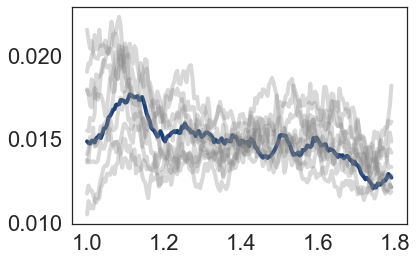

0.7800340056419373
0.5812243819236755
0.36129868030548096
0.12041786313056946
-0.12965255975723267
-0.3816063702106476
-0.6296417713165283
-0.8692443370819092
-1.0984598398208618
-1.3174093961715698
now running  GS
Using gp-exp parameterization.
Iter 1/500 - Loss: 14.026
Iter 51/500 - Loss: -2.744
Iter 101/500 - Loss: -2.826
Iter 151/500 - Loss: -2.837
-2.839012861251831 tensor(-2.8390, grad_fn=<NegBackward>)


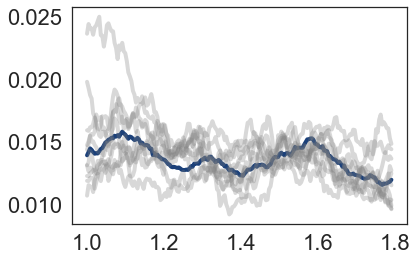

0.7835856080055237
0.5836868286132812
0.36538517475128174
0.12609244883060455
-0.12323341518640518
-0.37310081720352173
-0.6181354522705078
-0.8563370704650879
-1.0892924070358276
-1.3147377967834473
now running  JPM
Using gp-exp parameterization.
Iter 1/500 - Loss: 13.751
Iter 51/500 - Loss: -2.817
Iter 101/500 - Loss: -2.988
Iter 151/500 - Loss: -3.023
Iter 201/500 - Loss: -3.036
Iter 251/500 - Loss: -3.044
Iter 301/500 - Loss: -3.048
-3.048539161682129 tensor(-3.0485, grad_fn=<NegBackward>)


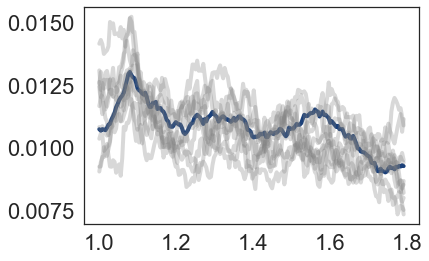

0.7912479639053345
0.5877759456634521
0.3701268136501312
0.1320444494485855
-0.11983421444892883
-0.3745497763156891
-0.624917209148407
-0.8667067885398865
-1.0983527898788452
-1.321250557899475
now running  MS
Using gp-exp parameterization.
Iter 1/500 - Loss: 14.385
Iter 51/500 - Loss: -2.662
Iter 101/500 - Loss: -2.755
Iter 151/500 - Loss: -2.767
-2.768977165222168 tensor(-2.7690, grad_fn=<NegBackward>)


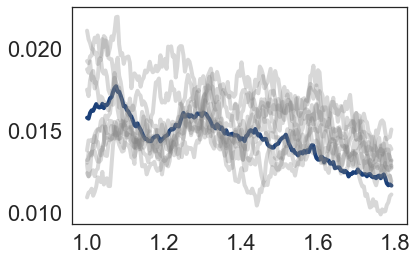

0.7798691391944885
0.5808621048927307
0.3612504303455353
0.1207217425107956
-0.12942864000797272
-0.3821050226688385
-0.6324726343154907
-0.8769910335540771
-1.1130443811416626
-1.338484525680542
now running  WFC
Using gp-exp parameterization.
Iter 1/500 - Loss: 13.906
Iter 51/500 - Loss: -2.750
Iter 101/500 - Loss: -2.881
Iter 151/500 - Loss: -2.900
Iter 201/500 - Loss: -2.905
-2.905431032180786 tensor(-2.9054, grad_fn=<NegBackward>)


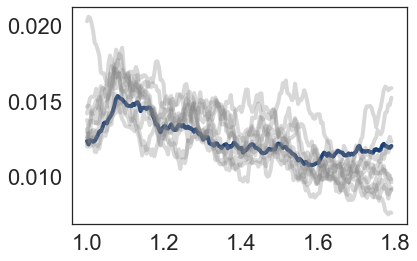

0.7853082418441772
0.5843412280082703
0.3659437894821167
0.12593048810958862
-0.12586945295333862
-0.3793729543685913
-0.6292864084243774
-0.8712751269340515
-1.1031606197357178
-1.3245419263839722
now running  COP
Using gp-exp parameterization.
Iter 1/500 - Loss: 13.151
Iter 51/500 - Loss: -2.483
Iter 101/500 - Loss: -2.550
Iter 151/500 - Loss: -2.557
-2.558645725250244 tensor(-2.5586, grad_fn=<NegBackward>)


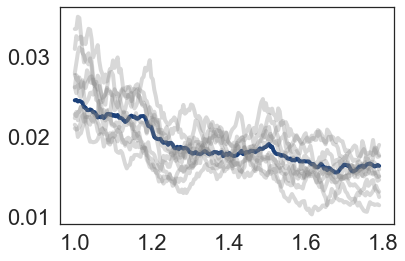

0.7717570662498474
0.5751380324363708
0.3550450801849365
0.11887390166521072
-0.12673339247703552
-0.37664085626602173
-0.626334011554718
-0.872161328792572
-1.1113146543502808
-1.3413406610488892
now running  CVX
Using gp-exp parameterization.
Iter 1/500 - Loss: 12.512
Iter 51/500 - Loss: -3.124
Iter 101/500 - Loss: -3.187
Iter 151/500 - Loss: -3.194
-3.194143533706665 tensor(-3.1941, grad_fn=<NegBackward>)


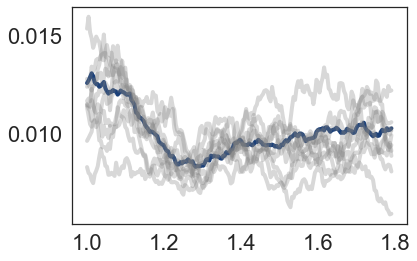

0.794218122959137
0.5897232890129089
0.37306469678878784
0.13818427920341492
-0.10908836126327515
-0.3594636619091034
-0.6069300174713135
-0.8497869372367859
-1.0859397649765015
-1.3128845691680908
now running  EOG
Using gp-exp parameterization.
Iter 1/500 - Loss: 13.383
Iter 51/500 - Loss: -2.652
Iter 101/500 - Loss: -2.745
Iter 151/500 - Loss: -2.762
Iter 201/500 - Loss: -2.767
-2.767080307006836 tensor(-2.7671, grad_fn=<NegBackward>)


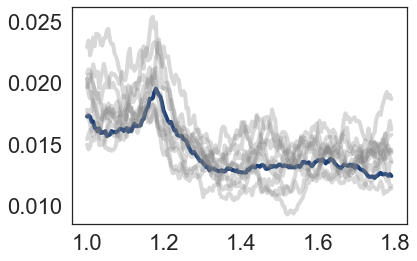

0.7811691761016846
0.5827669501304626
0.3647322356700897
0.12718917429447174
-0.11822761595249176
-0.3641211688518524
-0.6068462133407593
-0.8445554375648499
-1.0750938653945923
-1.2961429357528687
now running  SLB
Using gp-exp parameterization.
Iter 1/500 - Loss: 12.968
Iter 51/500 - Loss: -2.964
Iter 101/500 - Loss: -3.045
Iter 151/500 - Loss: -3.057
-3.059727430343628 tensor(-3.0597, grad_fn=<NegBackward>)


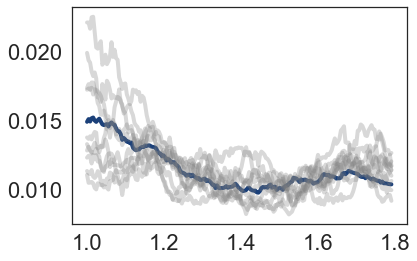

0.7867836952209473
0.5850406289100647
0.36788874864578247
0.13060295581817627
-0.11842338740825653
-0.370065838098526
-0.6204082369804382
-0.867045521736145
-1.1074048280715942
-1.339046597480774
now running  XOM
Using gp-exp parameterization.
Iter 1/500 - Loss: 12.376
Iter 51/500 - Loss: -3.199
Iter 101/500 - Loss: -3.270
Iter 151/500 - Loss: -3.279
-3.2798614501953125 tensor(-3.2799, grad_fn=<NegBackward>)


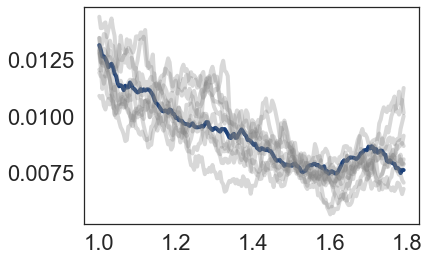

0.7942204475402832
0.5890586972236633
0.37192219495773315
0.1361386924982071
-0.11294876039028168
-0.36603081226348877
-0.6161594390869141
-0.8605756163597107
-1.0972329378128052
-1.323974609375


In [10]:
all_gpcv_paths, all_gpcv_vols = [], []
for i in range(10):
    print("now running ", tckrs[i])
    
    pred_vol = get_and_fit_gpcv(train_x, log_returns[i])
    vol_model = get_and_fit_vol_model(train_x, pred_vol)
    data_model = get_and_fit_data_model(train_x, train_y[i], pred_vol, vol_model)
    paths, vols = predict_prices(test_x, data_model)
    all_gpcv_paths.append(paths.detach())
    all_gpcv_vols.append(vols.detach())

In [12]:
px_paths = torch.stack(all_gpcv_paths)
vol_paths = torch.stack(all_gpcv_vols)

In [13]:
torch.save(f="ind_predictions.pt", obj={"paths": px_paths, "vol_paths": vol_paths, "test_y": test_y})